In [1]:
import numpy as np
import json
import pydicom
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_file
import cv2

In [2]:
np.random.seed(42)

In [3]:
dataset_ct_projections = json.load(open('/Mounts/rbg-storage1/datasets/NLST/full_nlst_google.json', 'r'))

In [5]:
def is_localizer(series_dict):
    return (series_dict["imageclass"][0] == 0) or ("LOCALIZER" in series_dict["imagetype"][0]) or ("TOP" in series_dict["imagetype"][0])

In [30]:
def load_input(path):
    dcm = pydicom.dcmread(path)
    min_val = np.min(dcm.pixel_array)
    min_max_pixel_array = dcm.pixel_array - min_val
    max_val = np.max(min_max_pixel_array)
    min_max_pixel_array = np.trunc(( min_max_pixel_array / max_val ) * 255).astype(np.uint8)
    min_max_pixel_array = cv2.equalizeHist(min_max_pixel_array)
    if hasattr(dcm, 'PhotometricInterpretation') and 'MONOCHROME2' in dcm.PhotometricInterpretation:
        min_max_pixel_array = 255 - min_max_pixel_array
    
    return min_max_pixel_array

In [26]:
def get_volume_dict(
        series_id, series_dict, exam_dict, pt_metadata, pid, split
    ):
        img_paths = series_dict["paths"]
        slice_locations = series_dict["img_position"]
        series_data = series_dict["series_data"]
        device = series_data["manufacturer"][0]
        screen_timepoint = series_data["study_yr"][0]
        assert screen_timepoint == exam_dict["screen_timepoint"]

        sorted_img_paths, sorted_slice_locs = order_slices(
            img_paths, slice_locations
        )

        exam_int = int(
            "{}{}{}".format(
                int(pid), int(screen_timepoint), int(series_id.split(".")[-1][-3:])
            )
        )
        sample = {
            "paths": sorted_img_paths,
            "slice_locations": sorted_slice_locs,
            "exam_str": "{}_{}".format(exam_dict["exam"], series_id),
            "exam": exam_int,
            "accession": exam_dict["accession_number"],
            "series": series_id,
            "study": series_data["studyuid"][0],
            "screen_timepoint": screen_timepoint,
            "pid": pid,
            "device": device,
            "institution": pt_metadata["cen"][0],
            "num_original_slices": len(series_dict["paths"]),
        }

        return sample

In [27]:
def order_slices(img_paths, slice_locations):
        sorted_ids = np.argsort(slice_locations)
        sorted_img_paths = np.array(img_paths)[sorted_ids].tolist()
        sorted_slice_locs = np.sort(slice_locations).tolist()

        return sorted_img_paths, sorted_slice_locs

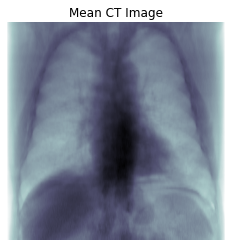

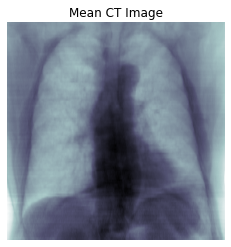

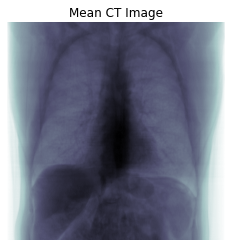

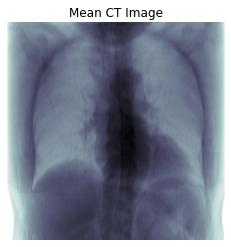

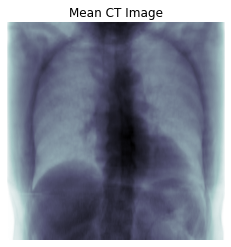

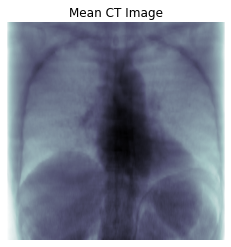

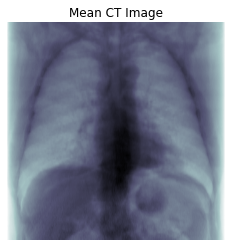

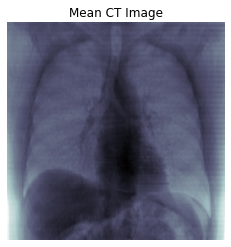

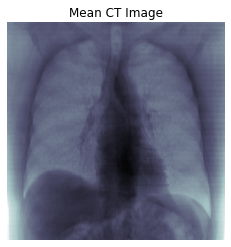

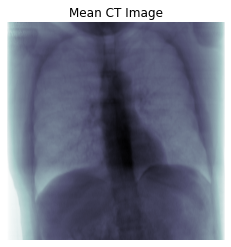

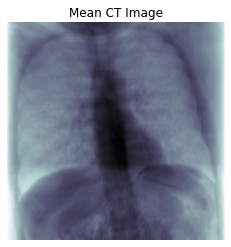

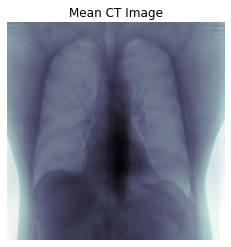

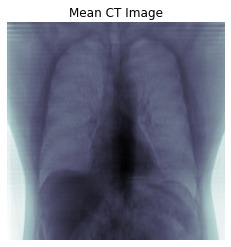

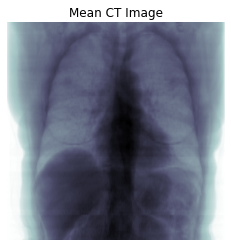

In [67]:
for mrn_row in dataset_ct_projections[:10]:
    pid, split, exams, pt_metadata = (
                mrn_row["pid"],
                mrn_row["split"],
                mrn_row["accessions"],
                mrn_row["pt_metadata"],
            )
    exam_dict = exams[0]
    for series_id, series_dict in exam_dict["image_series"].items():
        if not is_localizer(series_dict["series_data"]):
            sample = get_volume_dict(series_id, series_dict, exam_dict, pt_metadata, pid, split)
            ct = []
            for img in sample['paths']:
                try:
                    ct.append(load_input(img.replace("nlst-ct-png", "nlst-ct").replace(".png", "")))
                except:
                    print("failed to load image")
            im = cv2.resize(np.flipud(np.mean(np.stack(ct), axis=1)), (512, 512))
            plt.axis('off')
            plt.title(f"Mean CT Image", size=12,)
            plt.imshow(im, cmap=plt.cm.bone)
            plt.pause(0.001)

In [47]:
mrn_row = dataset_ct_projections[2]
pid, split, exams, pt_metadata = (
                mrn_row["pid"],
                mrn_row["split"],
                mrn_row["accessions"],
                mrn_row["pt_metadata"],
            )
exam_dict = exams[0]
for series_id, series_dict in exam_dict["image_series"].items():
    break
sample = get_volume_dict(series_id, series_dict, exam_dict, pt_metadata, pid, split)

In [48]:
ct = []
counter = 0
for img in sample['paths']:
    try:
        counter += 1
        ct.append(load_input(img.replace("nlst-ct-png", "nlst-ct").replace(".png", "")))
    except:
        print("failed to load image")

In [49]:
len(ct)

383

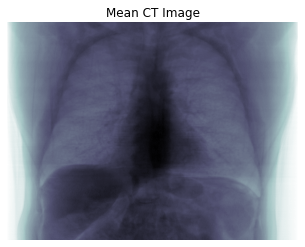

In [60]:
plt.axis('off')
plt.title(f"Mean CT Image", size=12,)
plt.imshow(np.flipud(np.mean(np.stack(ct), axis=1)), cmap=plt.cm.bone)

In [ ]:
# def get_thinnest_cut(exam_dict):
#         # volume that is not thin cut might be the one annotated; or there are multiple volumes with same num slices, so:
#         # use annotated if available, otherwise use thinnest cut
#         possibly_annotated_series = [
#             s in annotations_metadata
#             for s in list(exam_dict["image_series"].keys())
#         ]
#         series_lengths = [
#             len(exam_dict["image_series"][series_id]["paths"])
#             for series_id in exam_dict["image_series"].keys()
#         ]
#         thinnest_series_len = max(series_lengths)
#         thinnest_series_id = [
#             k
#             for k, v in exam_dict["image_series"].items()
#             if len(v["paths"]) == thinnest_series_len
#         ]
#         if any(possibly_annotated_series):
#             thinnest_series_id = list(exam_dict["image_series"].keys())[
#                 possibly_annotated_series.index(1)
#             ]
#         else:
#             thinnest_series_id = thinnest_series_id[0]
#         return thinnest_series_id

In [ ]:
ds = pydicom.dcmread(path)
fig.add_subplot(4, 4, i + 1)
plt.axis('off')
plt.title(f"T{i}", size=12,)
plt.text(0, 0, f"{img_dict[0]['acquisition_desc'] if 'acquisition_desc' in img_dict[0] else 'None'}", size=12)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)